In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
import base64
import array
import glob
import io
from datetime import datetime

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.models import save_model

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession



In [62]:
def load_test_img(img_folder):
    IMG_WIDTH=480
    IMG_HEIGHT=256
    img_a=[]
    img_a2=[]
    img_size=[]
    img_size2=[]
    i=0
    for filename in glob.iglob(img_folder + '**/*.png', recursive=True):
        img1= cv2.imread( filename, cv2.IMREAD_GRAYSCALE)
        
        name=os.path.basename(filename)
        name=os.path.splitext(name)[0]
        _1, img_arr1 = cv2.imencode('.png', img1)
        img_bytes1 = img_arr1.tobytes()
        img_b641 = base64.b64encode(img_bytes1)
        
        #---------------------------------------------
        
        img_b=base64.decodebytes(img_b641)
        
        img_ar = np.frombuffer(img_b, dtype=np.uint8)
        
        img_ = cv2.imdecode(img_ar, flags=cv2.IMREAD_GRAYSCALE)
        
        height, width = img_.shape[:2]
        img_size.append([width,height,name])
        img_=cv2.resize(img_,dsize=(IMG_WIDTH,IMG_HEIGHT),interpolation = cv2.INTER_AREA)
        
        img_=img_/255
        img_a.append(img_)
        
        i+=1
    return img_a,img_size

with tf.device('/CPU:0'):
    img_data_o,data_size_o=load_test_img('/home/eduardo/Desktop/DataTeste/data/1test/')
    img_data_o=np.array(img_data_o)
    img_data_o = img_data_o[..., tf.newaxis]
    print(img_data_o.shape)

(2, 256, 480, 1)


In [7]:
# BASE 64 - Byte Array 2

def create_dataset(img_folder,img_folder2):
    IMG_WIDTH=480
    IMG_HEIGHT=256
    img_a=[]
    img_a2=[]
    img_size=[]
    img_size2=[]
    i=0
    for filename in glob.iglob(img_folder + '**/*.png', recursive=True):
        img1= cv2.imread( filename, cv2.IMREAD_GRAYSCALE)
        
        name=os.path.basename(filename)
        name=os.path.splitext(name)[0]
        _1, img_arr1 = cv2.imencode('.png', img1)
        img_bytes1 = img_arr1.tobytes()
        img_b641 = base64.b64encode(img_bytes1)
        
        img2= cv2.imread(img_folder2+name+".png", cv2.IMREAD_GRAYSCALE)
        
        _2, img_arr2 = cv2.imencode('.png', img2)
        img_bytes2 = img_arr2.tobytes()
        img_b642 = base64.b64encode(img_bytes2)
        
        
        #---------------------------------------------
        
        img_b=base64.decodebytes(img_b641)
        img_ar = np.frombuffer(img_b, dtype=np.uint8)
        
        img_ = cv2.imdecode(img_ar, flags=cv2.IMREAD_GRAYSCALE)
        
        height, width = img_.shape[:2]
        print(img_.shape)
        pro
        img_size.append([width,height,name])
        img_=cv2.resize(img_,dsize=(IMG_WIDTH,IMG_HEIGHT),interpolation = cv2.INTER_AREA)
        
        img_=img_/255
        img_a.append(img_)
        
        #---2----
        
        img_b2=base64.decodebytes(img_b642)
        img_ar2 = np.frombuffer(img_b2, dtype=np.uint8)
        
        img_2 = cv2.imdecode(img_ar2, flags=cv2.IMREAD_GRAYSCALE)
        
        height2, width2 = img_2.shape[:2]
        img_size2.append([width2,height2,name])
        img_2=cv2.resize(img_2,dsize=(IMG_WIDTH,IMG_HEIGHT),interpolation = cv2.INTER_AREA)
        
        img_2=img_2/255
        img_a2.append(img_2)

        i+=1
    return img_a,img_a2,img_size,img_size2

with tf.device('/CPU:0'):
    img_data,img_clear,data_size,data_size_c=create_dataset('/home/eduardo/Desktop/DataTeste/data/original/1dirty/',
                                        '/home/eduardo/Desktop/DataTeste/data/original/2cleaned_example/')

    img_data=np.array(img_data)
    img_clear=np.array(img_clear)

    img_data = img_data[..., tf.newaxis]
    img_clear = img_clear[..., tf.newaxis]

    print(img_data.shape)
    print(img_clear.shape)

(258, 540)


NameError: name 'pro' is not defined

In [ ]:
n =2
i=0
plt.figure(figsize=(20, 10))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(img_clear[i+50])
  plt.title("Clear")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(img_data[i+50])
  plt.title("Dirtys")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
with tf.device('/CPU:0'):
    img_train_c, img_test_c,img_train_d,img_test_d = train_test_split(img_clear,img_data, test_size=0.2,random_state=42)
    print(img_train_c.shape)
    print(img_test_c.shape)
    print(img_train_d.shape)
    print(img_test_d.shape)

In [ ]:
def save_model(model,path):
    model.save(path+"autoencoder",save_format="tf")

In [ ]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            save_model(self.model,'/home/eduardo/Desktop/DataTeste/Models/conv2d_00/ESM/')
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))
            


In [ ]:
class Autoencoder(Model):

    def __init__(self, data):
        self.drop=0.2
        self.data=data
        self.cp_path='/home/eduardo/Desktop/DataTeste/Models/conv2d_00/'
        self.f1=128
        self.f2=64
        super(Autoencoder, self).__init__()  
        
        log_dir = "/home/eduardo/Desktop/DataTeste/Models/tensorboard/" + datetime.now().strftime("%Y%m%d-%H%M%S")
        self.tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        self.cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self.cp_path,
                                                 save_weights_only=False,
                                                 save_freq='epoch',period=25)
        self.batch_print_callback = LambdaCallback(on_epoch_end=self.test)
        
        self.encoder = tf.keras.Sequential([
        layers.Input(shape=(256, 480, 1)),
        layers.Conv2D(self.f1, 3, strides=2, padding='same', name='cv1'),
        layers.BatchNormalization(name='bn_1'),
        layers.LeakyReLU(name='lrelu_1'),
        layers.Dropout(rate = self.drop),
            
        layers.Conv2D(self.f2, 3, strides=2, padding='same', name='cv2'),
        layers.BatchNormalization(name='bn_2'),
        layers.LeakyReLU(name='lrelu_2'),
        layers.Dropout(rate = self.drop),

        ])
        
        self.decoder = tf.keras.Sequential([  
 
        layers.Conv2DTranspose(self.f2, kernel_size=3, strides=2,activation='relu', padding='same', name='cv_transpose_3'),
        layers.BatchNormalization(name='bn_3'),
        layers.LeakyReLU(name='lrelu_3'),
        layers.Dropout(rate = self.drop),
            
        layers.Conv2DTranspose(self.f1, kernel_size=3, strides=2,activation='relu',padding='same', name='cv_transpose_4'),
        layers.BatchNormalization(name='bn_4'),
        layers.LeakyReLU(name='lrelu_4'),
        layers.Dropout(rate = self.drop),
            
        layers.Conv2DTranspose(1, kernel_size=3, strides= 1,padding='same', activation='sigmoid', name='cv_transpose_6')
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def test(self,epoch,logs={}):

        x = self.data    
        if not epoch%20:
            print("Save Decoded")
            with tf.GradientTape() as tape:
                y_pred = self(x, training=True)  
                y_pred=np.array(y_pred)
                y_pred=y_pred*255
                for i in range(len(y_pred)):
                    cv2.imwrite("/home/eduardo/Desktop/DataTeste/decoded/"+str(epoch)+"-"+str(i)+".png",y_pred[i])
        return None
    
with tf.device('/CPU:0'):  
    autoencoder = Autoencoder(img_data_o)

In [ ]:
# autoencoder.encoder.summary()

In [ ]:
# autoencoder.decoder.summary()

In [ ]:
with tf.device('/CPU:0'):
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
with tf.device('/GPU:0'):
    print(img_data.shape)
    print(img_clear.shape)

    autoencoder.fit(img_train_d,img_train_c ,
                    epochs=15000,
                    shuffle=True,
                    batch_size=8,
                    validation_data=(img_test_d,img_test_c),
                    callbacks=[EarlyStoppingAtMinLoss(70),
                               autoencoder.batch_print_callback,
                               autoencoder.cp_callback,
                               autoencoder.tensorboard_callback
                               ])

In [ ]:
# Save Model

save_model(autoencoder,'/home/eduardo/Desktop/DataTeste/Models/conv2d_00/test/')

In [26]:
def load_model(path):
    model = tf.keras.models.load_model(path) # Load the model
    return model

with tf.device('/CPU:0'):
    autoencoder_r=load_model('/home/eduardo/Desktop/DataTeste/Models/conv2d_00/ESM/autoencoder/')



In [27]:
def load_test_img(img_folder):
    IMG_WIDTH=480
    IMG_HEIGHT=256
    img_a=[]
    img_a2=[]
    img_size=[]
    img_size2=[]
    i=0
    for filename in glob.iglob(img_folder + '**/*.png', recursive=True):
        img1= cv2.imread( filename, cv2.IMREAD_GRAYSCALE)
        
        name=os.path.basename(filename)
        name=os.path.splitext(name)[0]
#         img=cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
        _1, img_arr1 = cv2.imencode('.png', img1)
        img_bytes1 = img_arr1.tobytes()
        img_b641 = base64.b64encode(img_bytes1)
        
        #---------------------------------------------
        
        img_b=base64.decodebytes(img_b641)
        img_ar = np.frombuffer(img_b, dtype=np.uint8)
        
        img_ = cv2.imdecode(img_ar, flags=cv2.IMREAD_GRAYSCALE)
        
        height, width = img_.shape[:2]
        img_size.append([width,height,name])
        img_=cv2.resize(img_,dsize=(IMG_WIDTH,IMG_HEIGHT),interpolation = cv2.INTER_AREA)
        
        img_=img_/255
        img_a.append(img_)
        
        i+=1
    return img_a,img_size

with tf.device('/CPU:0'):
    img_data_t,data_size_t=load_test_img('/home/eduardo/Desktop/DataTeste/data_cleaner/data/1dirty_ORI')
    img_data_t=np.array(img_data_t)
    img_data_t = img_data_t[..., tf.newaxis]
    print(img_data_t.shape)

(216, 256, 480, 1)


In [28]:
def process_image(model,img_data_in,path_out,data_size_in):

    encoded_imgs=[]
    decoded_imgs=[]
    img_data_d=[]
    img_decoded_d=[]

    for i in range(len(img_data_t)):
        img_data=img_data_in[i]
        img_data = img_data[np.newaxis,...]
        encoded_imgs = autoencoder_r.encoder(img_data).numpy()
        decoded_imgs = autoencoder_r.decoder(encoded_imgs).numpy()
        
        img_data_d.append(cv2.resize(img_data_in[i], dsize=(data_size_in[i][0],data_size_in[i][1]),interpolation = cv2.INTER_AREA))
        img_decoded_d.append(cv2.resize(decoded_imgs[0], dsize=(data_size_t[i][0],data_size_t[i][1]),interpolation = cv2.INTER_AREA))
    
    img_data_d=np.array(img_data_d)*255
    img_decoded_d=np.array(img_decoded_d)*255
    
    print(img_data_d.shape)
    print(img_decoded_d.shape)
    
    return(img_data_d,img_decoded_d)
  
    
with tf.device('/GPU:0'):
    img_dirty,img_cleaned=process_image(autoencoder_r,img_data_t,None,data_size_t)

(216,)
(216,)


/home/eduardo/anaconda3/envs/tsteroit/lib/python3.6/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/eduardo/anaconda3/envs/tsteroit/lib/python3.6/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


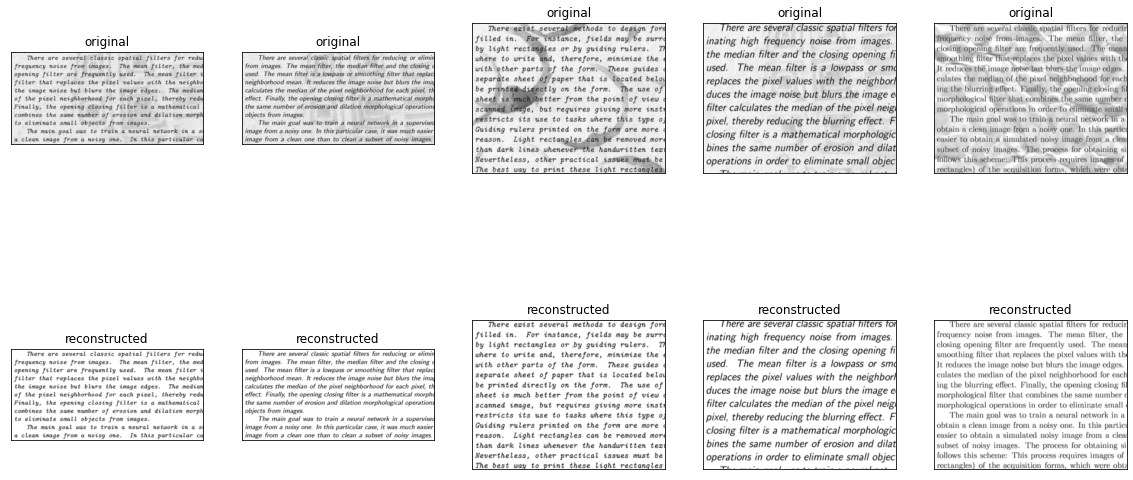

In [29]:
n =5
i=0
plt.figure(figsize=(20, 10))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(img_dirty[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(img_cleaned[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:

def save_decoded_imgs(path,imgs):
    for x in range(len(imgs)):
#         print(data_size_o[x][2])
        cv2.imwrite(path+data_size_t[x][2]+".png",imgs[x])
                    
save_decoded_imgs('/home/eduardo/Desktop/DataTeste/data_decoded/',img_cleaned)
